# Investigating the KNN algorithm as an alternative classifier

In [205]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)


transform = v2.Compose(
    [
        v2.Resize(size=(400, 400)),
        v2.ToDtype(
            torch.float32, scale=True
        ),  # Use float32 datatype to enable training on Apple silicon GPU
        # v2.Grayscale(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [206]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [207]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    train_size=0.8,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [208]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler

dataset = RoastDefectsDataset(
    csv_file="data/beans.csv",
    root_dir="data/processed",
    transform=transform,
)

train_sampler = ImbalancedDatasetSampler(
    dataset, labels=train["defect_class"], indices=list(train.index)
)
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=len(train))
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=len(test))

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}

## Build datasets

In [209]:
X_train = []
y_train = []
X_test = []
y_test = []
for _, (data, label) in enumerate(train_loader):
    X_train = data.squeeze()
    y_train = label.squeeze()

for _, (data, label) in enumerate(test_loader):
    X_test = data.squeeze()
    y_test = label.squeeze()

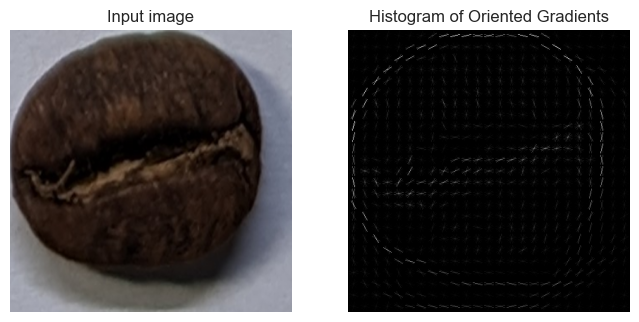

In [210]:
from skimage.exposure import exposure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from skimage.feature import hog
import matplotlib.pyplot as plt

img = X_train[0]
fd, hog_image = hog(
    img.permute(1, 2, 0),
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(img.permute(1, 2, 0), cmap=plt.cm.gray)
ax1.set_title("Input image")

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis("off")
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title("Histogram of Oriented Gradients")
plt.show()

# for k in [1, 3, 5, 7, 9, 12, 15, 20]:
#
#     print("K = ", k)
#
#     knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
#     knn.fit(X_train, y_train)
#     preds = knn.predict(X_test)
#     print(classification_report(y_test, preds, zero_division=0))

In [211]:
hog_features_train = []
hog_features_test = []

for img in X_train:
    fd = hog(img.permute(1, 2, 0), channel_axis=-1)
    hog_features_train.append(fd)

for img in X_test:
    fd = hog(img.permute(1, 2, 0), channel_axis=-1)
    hog_features_test.append(fd)

In [214]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(hog_features_train, y_train)
preds = knn.predict(hog_features_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.17      0.40      0.24        10
           1       0.66      0.82      0.73       263
           2       0.38      0.05      0.09        59
           3       0.36      0.24      0.29        21
           4       0.57      0.51      0.53       196
           5       0.11      0.11      0.11         9

    accuracy                           0.59       558
   macro avg       0.37      0.35      0.33       558
weighted avg       0.57      0.59      0.56       558


<Axes: >

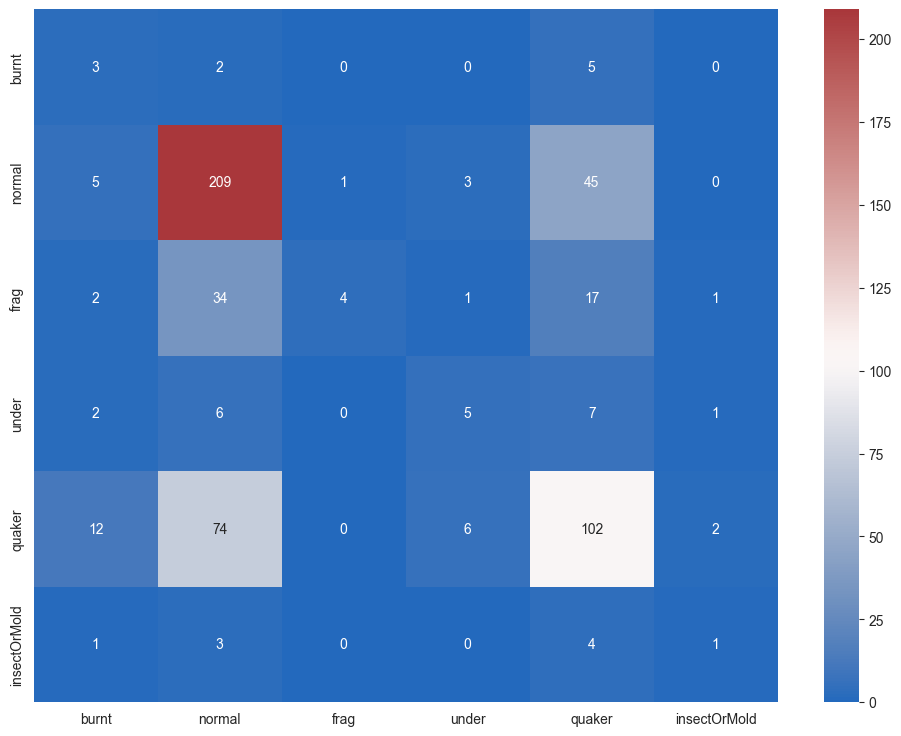

In [213]:
from torcheval.metrics import MulticlassConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(preds), y_test)

confs = matrix.compute()


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=DEFECT_CLASSES.keys(),
    yticklabels=DEFECT_CLASSES.keys(),
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)